In [1]:
import os
from ngs import *
import numpy as np
import pandas as pd
from scipy.stats import norm 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import font_manager as fm

repo_root = os.path.dirname(os.getcwd())

NGS package imported


In [2]:
#path to NGS data
p1_nnk = os.path.join(repo_root, "data", "ngs_data", "Rep_1")
p2_nnk = os.path.join(repo_root, "data", "ngs_data", "Rep_2")

#Allowed mutations with NNK is everything
mut_dict_nnk = {
0: ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'T', 'V', 'W', 'Y'], #S
1: ['C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'], #A
2: ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'T', 'V', 'W', 'Y'], #S
3: ['A', 'C', 'D', 'E', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'], #F
4: ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W'], #Y
5: ['A', 'C', 'D', 'E', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'], #F
6: ['A', 'C', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'], #D
7: ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'V', 'W', 'Y'], #T
8: ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W'], #Y
9: ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'], #I 
}

#AF1 97 WT Mutation string
wt = 'SASFYFDTYI'

#DMD data objects
d1_nnk = NGS_DMD(
    sequence_type = 'mutations', samples = ['R2', 'R3', 'R5', 'R6', 'R7'],
    path = p1_nnk, wild_type = wt, mutations_dict = mut_dict_nnk
)

d2_nnk = NGS_DMD(
    sequence_type = 'mutations', samples = ['R2', 'R3', 'R5', 'R6', 'R7'],
    path = p2_nnk, wild_type = wt, mutations_dict = mut_dict_nnk
)

['Mutation_1001.csv', 'Mutation_1003.csv', 'Mutation_1005.csv', 'Mutation_1007.csv', 'Mutation_1009.csv']
['Mutation_1001.csv', 'Mutation_1003.csv', 'Mutation_1005.csv', 'Mutation_1007.csv', 'Mutation_1009.csv']


In [3]:
full_clones = set()
for r in d1_nnk.samples:
    full_clones = full_clones.union(common_clones({d1_nnk: [r], d2_nnk: [r]}))
full_clones = [c for c in full_clones if "*" not in c]

clones = common_clones({
    d1_nnk: ['R2', 'R3', 'R5', 'R6'],
    d2_nnk: ['R2', 'R3', 'R5', 'R6']
})
potential_clones = [c for c in clones if "*" not in c]

d_nnk = ngs_analysis(
    replicates = [d1_nnk, d2_nnk],
    common_rounds = ['R2', 'R3', 'R5', 'R6', 'R7'],
    clone_set = full_clones
)

# generate data matrix containing clones and averaged frequencies
d_nnk.generate_D()

# generate PSSMs for each round
for sample in d_nnk.samples:
    d_nnk.generate_PSSM(sample, pseudocount="proportional")

# generate PSERMs for rounds of interest and score all clones
d_nnk.generate_PSERM(In_sample = "R5", Out_sample = "R6")
d_nnk.generate_PSERM(In_sample = "R6", Out_sample = "R7")
d_nnk.score_all_clones_mp()

Generating MSA.


100%|███████████████████████████████████████████████| 10/10 [00:00<00:00, 76.79it/s]


Done in 0.01 minutes


In [5]:
def calculate_pserm_score_error(seq, d_nnk, round_out, round_in):
    error_sum = 0
    factor = 1 / np.log(2)**2
        
    for p, aa in enumerate(seq):
        C_out = d_nnk.Counts[round_out].loc[aa, p]
        C_in = d_nnk.Counts[round_in].loc[aa, p]
        error_sum += factor * (1/C_out + 1/C_in)
    
    return np.sqrt(error_sum)

def calculate_er_score_error(seq, d_nnk, round_out, round_in):
    factor = 1 / np.log(2)**2
    C_out = d_nnk.counts.loc[seq, round_out]
    C_in = d_nnk.counts.loc[seq, round_in]
    
    error_sum = factor * (1/C_out + 1/C_in)
    
    return np.sqrt(error_sum)

In [6]:
clones = ['97A3', '97A5', '97A7', '97A34', '97A35', '97']

metrics = pd.read_csv(os.path.join(repo_root, "data", "clone_names.csv"), index_col = 0)
metrics = metrics.loc[metrics['Clone'].isin(clones)]

ec50s = pd.read_csv(os.path.join(repo_root, "results", "Figure-3-Fits.csv"), index_col = 0)
metrics = metrics.merge(
    ec50s[['EC50', 'EC50_std']],
    left_on='Clone',
    right_index=True,
    how='left'
)
metrics["1/EC50"] = 1/metrics["EC50"]
metrics["1/EC50_err"] = metrics['EC50_std'] / (metrics['EC50'] ** 2)

metrics["R6_score"] = d_nnk.scores.loc[metrics.index, "R6 PSERM Score"]
metrics["R7_score"] = d_nnk.scores.loc[metrics.index, "R7 PSERM Score"]

metrics["R6_score_err"] = metrics.index.map(
    lambda clone_id: calculate_pserm_score_error(clone_id, d_nnk, 'R6', 'R5')
)
metrics["R7_score_err"] = metrics.index.map(
    lambda clone_id: calculate_pserm_score_error(clone_id, d_nnk, 'R7', 'R6')
)

metrics["R6_freq"] = d_nnk.D.loc[metrics.index, "R6"]
metrics["R7_freq"] = d_nnk.D.loc[metrics.index, "R7"]

metrics["R6_freq_err"] = np.sqrt(d_nnk.counts.loc[metrics.index, "R6"] / d_nnk.counts.sum()['R6']**2)
metrics["R7_freq_err"] = np.sqrt(d_nnk.counts.loc[metrics.index, "R7"] / d_nnk.counts.sum()['R7']**2)

metrics["R6_ger"] = np.log2(d_nnk.D.loc[metrics.index, "R6"] / d_nnk.D.loc[metrics.index, "R2"])
metrics["R7_ger"] = np.log2(d_nnk.D.loc[metrics.index, "R7"] / d_nnk.D.loc[metrics.index, "R2"])

metrics["R6_ger_err"] = metrics.index.map(
    lambda clone_id: calculate_er_score_error(clone_id, d_nnk, 'R6', 'R2')
)
metrics["R7_ger_err"] = metrics.index.map(
    lambda clone_id: calculate_er_score_error(clone_id, d_nnk, 'R7', 'R2')
)

metrics["R6_ler"] = np.log2(d_nnk.D.loc[metrics.index, "R6"] / d_nnk.D.loc[metrics.index, "R5"])
metrics["R7_ler"] = np.log2(d_nnk.D.loc[metrics.index, "R7"] / d_nnk.D.loc[metrics.index, "R6"])

metrics["R6_ler_err"] = metrics.index.map(
    lambda clone_id: calculate_er_score_error(clone_id, d_nnk, 'R6', 'R5')
)
metrics["R7_ler_err"] = metrics.index.map(
    lambda clone_id: calculate_er_score_error(clone_id, d_nnk, 'R7', 'R6')
)

metrics = pd.concat([metrics.iloc[1:], metrics.iloc[[0]]])
metrics

,Clone,EC50,EC50_std,1/EC50,1/EC50_err,R6_score,R7_score,R6_score_err,R7_score_err,R6_freq,...,R6_freq_err,R7_freq_err,R6_ger,R7_ger,R6_ger_err,R7_ger_err,R6_ler,R7_ler,R6_ler_err,R7_ler_err
Mut_Str,,,,,,,,,,,,,,,,,,,,,
GTRYNFDTYI,97A3,1.307811,0.547231,0.764637,0.319949,2.780295,7.609858,0.066577,0.048221,0.001980,...,0.000031,0.000059,5.234630,7.006798,0.148219,0.147019,0.920555,1.772168,0.038985,0.025859
SSSFYYDTYI,97A5,0.967946,0.590364,1.033116,0.630112,0.870239,1.583418,0.038293,0.037926,0.000003,...,0.000001,0.000003,0.651085,2.499930,0.904257,0.779144,1.163361,1.848845,0.995554,0.619727
SAIFYYDTYI,97A7,0.376159,0.131062,2.658451,0.926260,0.792741,1.492740,0.070598,0.075540,0.000008,...,0.000002,0.000002,1.609264,2.116601,0.733967,0.711876,2.028432,0.507336,0.801733,0.461441
SASFYYATYI,97A34,0.216718,0.082168,4.614288,1.749492,1.548800,2.289720,0.031301,0.024664,0.000010,...,0.000002,0.000005,-3.648123,-1.489423,0.336629,0.183677,1.262897,2.158700,0.603523,0.358546
SASFYYDTYN,97A35,1.418338,0.228755,0.705051,0.113713,1.187551,1.561958,0.051592,0.050052,0.000009,...,0.000002,0.000005,-2.552199,-0.353850,0.361053,0.214221,1.018972,2.198349,0.583788,0.366909
SASFYFDTYI,97,4.733772,0.925499,0.211248,0.041301,-0.002295,-0.102485,0.004574,0.004593,0.945672,...,0.000678,0.000682,0.057248,0.004033,0.001521,0.001552,-0.009909,-0.053216,0.001476,0.001496


In [7]:
def top_k_threshold(s, k=40):
    """Return the k-th largest value (0-based) including ties via >= threshold.
       If fewer than k non-NA values, return the smallest present."""
    s = s.dropna().sort_values(ascending=False)
    if len(s) == 0:
        return np.nan
    if len(s) < k:
        return s.iloc[-1]
    return s.iloc[k-1]

def apply_fill_mask(bar_container, mask, edge_color, lw=1.0):
    """Fill bars when mask=True; otherwise hollow with facecolor='none'."""
    for rect, keep_fill in zip(bar_container.patches, mask):
        if keep_fill:
            rect.set_facecolor(edge_color)
            rect.set_edgecolor(edge_color)
        else:
            rect.set_facecolor('none')
            rect.set_edgecolor(edge_color)
            rect.set_linewidth(lw)

def ztest_vs_baseline(mu: pd.Series, se: pd.Series, baseline_mask: pd.Series) -> pd.Series:
    """One-sided z-test for H1: mu > mu_baseline; returns p-values aligned to mu index."""
    mu0 = mu.loc[baseline_mask].iloc[0]
    se0 = se.loc[baseline_mask].iloc[0]
    se_diff = np.sqrt(se**2 + se0**2)
    z = (mu - mu0) / se_diff
    p = pd.Series(norm.sf(z), index=mu.index)
    p.loc[baseline_mask] = np.nan   # don't test baseline vs itself
    return p

def annotate_stars(ax, bars, pvals, se, fontprops, pad_frac=0.03, log_pad_factor=1.10):
    ymin, ymax = ax.get_ylim()
    logy = ax.get_yscale() == 'log'

    # allow Series or arrays
    if isinstance(se, (pd.Series,)):
        se_vals = se.to_numpy()
    else:
        se_vals = np.asarray(se)
    if isinstance(pvals, (pd.Series,)):
        p_vals = pvals.to_numpy()
    else:
        p_vals = np.asarray(pvals)

    for i, (rect, p) in enumerate(zip(bars.patches, p_vals)):
        if not np.isfinite(p) or p >= 0.05:
            continue
        mu = rect.get_height()
        se_i = se_vals[i] if np.isfinite(se_vals[i]) else 0.0
        top = mu + se_i

        if logy:
            if top <= 0:   # safety for log axes
                continue
            y = top * log_pad_factor
        else:
            y = top + (ymax - ymin) * pad_frac

        x = rect.get_x() + rect.get_width() / 2.0
        ax.text(x, y, "*", ha="center", va="bottom", fontproperties=fontprops)

In [8]:
# PSERM scores
thr_R6_score = top_k_threshold(d_nnk.scores.loc[potential_clones, "R6 PSERM Score"])
thr_R7_score = top_k_threshold(d_nnk.scores.loc[potential_clones, "R7 PSERM Score"])

# Frequency
thr_R6_freq  = top_k_threshold(d_nnk.D.loc[potential_clones, "R6"])
thr_R7_freq  = top_k_threshold(d_nnk.D.loc[potential_clones, "R7"])

# Guard against divide-by-zero in ER with errstate
with np.errstate(divide='ignore', invalid='ignore'):
    # Global ER = log2(Ri / R2)
    thr_R6_ger = top_k_threshold(np.log2(d_nnk.D.loc[potential_clones, "R6"] / d_nnk.D.loc[potential_clones, "R2"]))
    thr_R7_ger = top_k_threshold(np.log2(d_nnk.D.loc[potential_clones, "R7"] / d_nnk.D.loc[potential_clones, "R2"]))

    # Local ER
    thr_R6_ler = top_k_threshold(np.log2(d_nnk.D.loc[potential_clones, "R6"] / d_nnk.D.loc[potential_clones, "R5"]))
    thr_R7_ler = top_k_threshold(np.log2(d_nnk.D.loc[potential_clones, "R7"] / d_nnk.D.loc[potential_clones, "R6"]))

m_R6_score = (metrics["R6_score"] > thr_R6_score).fillna(False).to_numpy()
m_R7_score = (metrics["R7_score"] > thr_R7_score).fillna(False).to_numpy()

m_R6_freq  = (metrics["R6_freq"]  > thr_R6_freq ).fillna(False).to_numpy()
m_R7_freq  = (metrics["R7_freq"]  > thr_R7_freq ).fillna(False).to_numpy()

m_R6_ger   = (metrics["R6_ger"]   > thr_R6_ger  ).fillna(False).to_numpy()
m_R7_ger   = (metrics["R7_ger"]   > thr_R7_ger  ).fillna(False).to_numpy()

m_R6_ler   = (metrics["R6_ler"]   > thr_R6_ler  ).fillna(False).to_numpy()
m_R7_ler   = (metrics["R7_ler"]   > thr_R7_ler  ).fillna(False).to_numpy()

is_97 = (metrics['Clone'].astype(str) == '97').to_numpy()

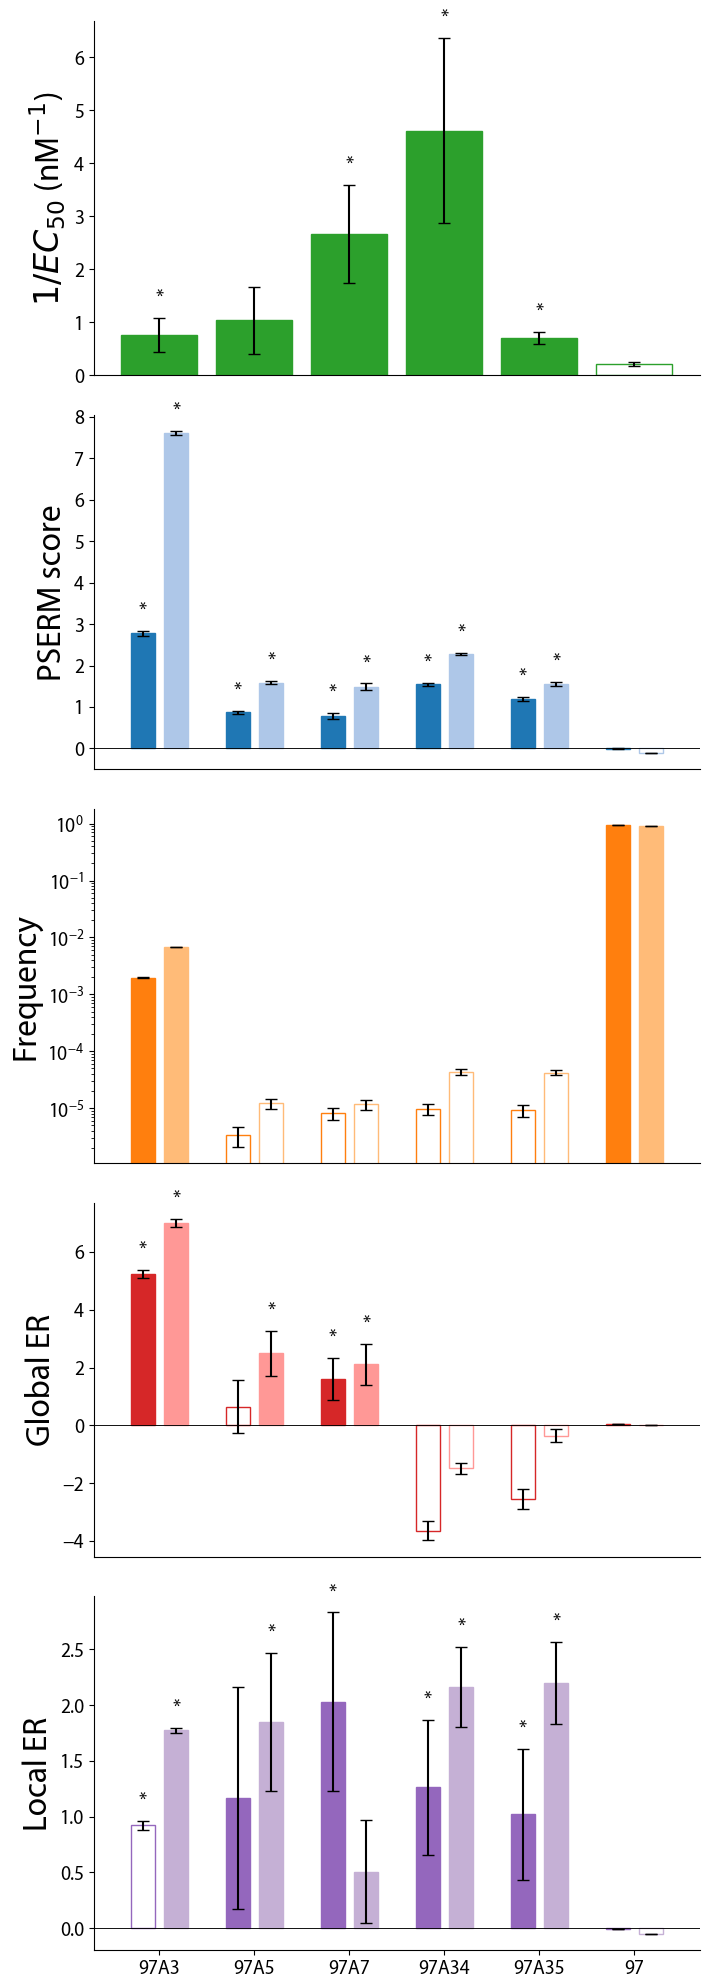

In [37]:
# Font properties
fpath = "/Library/Fonts/Myriad Pro Regular.ttf"
if os.path.exists(fpath):
    prop = fm.FontProperties(fname=fpath, size=24)   # for axis labels
    propg = fm.FontProperties(fname=fpath, size=14)  # for tick labels
else:
    prop = fm.FontProperties(size=24)
    propg = fm.FontProperties(size=14)

fig, axes = plt.subplots(5, 1, figsize=(7.2, 20), sharex=True)

cmap = plt.get_cmap("tab20")
bar_width = .35
x = np.arange(len(metrics))

# 1) 1/EC50
bars_ec50 = axes[0].bar(
    x,
    metrics['1/EC50'],
    yerr=metrics["1/EC50_err"],
    capsize = 4,
    color=cmap(4)
)
axes[0].set_ylabel(r'$1/EC_{50}$ (nM$^{-1}$)', fontproperties=prop)

# 2) PSERM score
bars_r6_score = axes[1].bar(
    x - bar_width/2, 
    metrics['R6_score'], 
    yerr = metrics['R6_score_err'],
    capsize = 4,
    width=0.25, 
    color=cmap(0)
)
bars_r7_score = axes[1].bar(
    x + bar_width/2, 
    metrics['R7_score'], 
    yerr = metrics['R7_score_err'],
    capsize = 4,
    width=0.25, 
    color=cmap(1)
)
axes[1].set_ylabel('PSERM score', fontproperties=prop)

# 3) Frequency (log scale)
bars_r6_freq = axes[2].bar(
    x - bar_width/2, 
    metrics['R6_freq'], 
    yerr = metrics['R6_freq_err'],
    capsize = 4,
    width=0.25, 
    color=cmap(2)
)
bars_r7_freq = axes[2].bar(
    x + bar_width/2, 
    metrics['R7_freq'], 
    yerr = metrics['R7_freq_err'],
    capsize = 4,
    width=0.25, 
    color=cmap(3)
)
axes[2].set_yscale('log')
axes[2].set_ylabel('Frequency', fontproperties=prop)

# 4) Global ER
bars_r6_ger = axes[3].bar(
    x - bar_width/2, 
    metrics['R6_ger'], 
    yerr = metrics['R6_ger_err'],
    capsize = 4,
    width=0.25, 
    color=cmap(6)
)
bars_r7_ger = axes[3].bar(
    x + bar_width/2, 
    metrics['R7_ger'], 
    yerr = metrics['R7_ger_err'],
    capsize = 4,
    width=0.25, 
    color=cmap(7)
)
axes[3].set_ylabel('Global ER', fontproperties=prop)

# 5) Local ER
bars_r6_ler = axes[4].bar(
    x - bar_width/2, 
    metrics['R6_ler'],
    yerr = metrics['R6_ler_err'],
    capsize = 4,
    width=0.25, 
    color=cmap(8)
)
bars_r7_ler = axes[4].bar(
    x + bar_width/2, 
    metrics['R7_ler'], 
    yerr = metrics['R7_ler_err'],
    capsize = 4,
    width=0.25, 
    color=cmap(9)
)
axes[4].set_ylabel('Local ER', fontproperties=prop)

# X-axis labels
axes[-1].set_xticks(x)
axes[-1].set_xticklabels(metrics['Clone'], fontproperties=propg)

# Hide x ticks/labels for plots 1–4
for ax in axes[:-1]:
    ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)

# Apply tick font to all y-axis ticks
for ax in axes:
    for label in ax.get_yticklabels():
        label.set_fontproperties(propg)

# Zero line
for ax in axes:
    ax.axhline(y=0, color="k", linewidth=0.65)

# Clean up appearance
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# ----------------------------
# apply fill/hollow rules
# ----------------------------
apply_fill_mask(bars_r6_score, m_R6_score, edge_color=cmap(0))
apply_fill_mask(bars_r7_score, m_R7_score, edge_color=cmap(1))

apply_fill_mask(bars_r6_freq,  m_R6_freq,  edge_color=cmap(2))
apply_fill_mask(bars_r7_freq,  m_R7_freq,  edge_color=cmap(3))

apply_fill_mask(bars_r6_ger,   m_R6_ger,   edge_color=cmap(6))
apply_fill_mask(bars_r7_ger,   m_R7_ger,   edge_color=cmap(7))

apply_fill_mask(bars_r6_ler,   m_R6_ler,   edge_color=cmap(8))
apply_fill_mask(bars_r7_ler,   m_R7_ler,   edge_color=cmap(9))

# panel 1: hollow '97' only, fill others
apply_fill_mask(bars_ec50, ~is_97, edge_color=cmap(4))
for rect, flag in zip(bars_ec50.patches, is_97):
    if flag:
        rect.set_facecolor('none')
        rect.set_edgecolor(cmap(4))
        rect.set_linewidth(1.0)

is_97 = metrics['Clone'].astype(str) == '97'

# EC50 panel
se_inv = metrics['EC50_std'] / (metrics['EC50'] ** 2)
p = ztest_vs_baseline(metrics['1/EC50'], se_inv, is_97)
annotate_stars(axes[0], bars_ec50, p, se_inv, fontprops=propg)

# PSERM
p = ztest_vs_baseline(metrics['R6_score'], metrics['R6_score_err'], is_97)
annotate_stars(axes[1], bars_r6_score, p, metrics['R6_score_err'], fontprops=propg)

p = ztest_vs_baseline(metrics['R7_score'], metrics['R7_score_err'], is_97)
annotate_stars(axes[1], bars_r7_score, p, metrics['R7_score_err'], fontprops=propg)

# Frequency (log axis)
p = ztest_vs_baseline(metrics['R6_freq'], metrics['R6_freq_err'], is_97)
annotate_stars(axes[2], bars_r6_freq, p, metrics['R6_freq_err'], fontprops=propg)

p = ztest_vs_baseline(metrics['R7_freq'], metrics['R7_freq_err'], is_97)
annotate_stars(axes[2], bars_r7_freq, p, metrics['R7_freq_err'], fontprops=propg)

# Global ER
p = ztest_vs_baseline(metrics['R6_ger'], metrics['R6_ger_err'], is_97)
annotate_stars(axes[3], bars_r6_ger, p, metrics['R6_ger_err'], fontprops=propg)

p = ztest_vs_baseline(metrics['R7_ger'], metrics['R7_ger_err'], is_97)
annotate_stars(axes[3], bars_r7_ger, p, metrics['R7_ger_err'], fontprops=propg)

# Local ER
p = ztest_vs_baseline(metrics['R6_ler'], metrics['R6_ler_err'], is_97)
annotate_stars(axes[4], bars_r6_ler, p, metrics['R6_ler_err'], fontprops=propg)

p = ztest_vs_baseline(metrics['R7_ler'], metrics['R7_ler_err'], is_97)
annotate_stars(axes[4], bars_r7_ler, p, metrics['R7_ler_err'], fontprops=propg)

plt.tight_layout()
plt.savefig(os.path.join(repo_root, "results", "Figure-S8.pdf"), transparent = True, dpi = 600)
plt.show()